In [1]:
import dimod
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial.distance import cdist

from dimod import Binary, Integer, quicksum
from dwave.system import LeapHybridCQMSampler
import hybrid

import tqdm

In [2]:
def tsp_plotter(points, soln):
    fig, ax = plt.subplots(2, sharex=True, sharey=True)         # Prepare 2 plots
    ax[0].set_title('Raw nodes')
    ax[1].set_title('Optimized tour')
    ax[0].scatter(points[:, 0], points[:, 1])             # plot A
    ax[1].scatter(points[:, 0], points[:, 1])             # plot B
    start_node = 0
    distance = 0.
    N = points.shape[0]
    for i in range(1,N+1):
        start_pos = points[start_node]
        next_node = soln[i] # needed because of MIP-approach used for TSP
        end_pos = points[next_node]
        ax[1].annotate("",
                xy=start_pos, xycoords='data',
                xytext=end_pos, textcoords='data',
                arrowprops=dict(arrowstyle="<-",
                                connectionstyle="arc3"))
        distance += np.linalg.norm(end_pos - start_pos)
        start_node = next_node
    
    textstr = "N nodes: %d\nTotal length: %.3f" % (N, distance)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax[1].text(0.7, 0.95, textstr, transform=ax[1].transAxes, fontsize=11, # Textbox
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()

In [3]:
df = pd.read_csv('data/tsp_poi.csv').sort_values(by='y', ascending=False)
points = df.values
## Parameters
N = len(points)
C = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        C[i,j] = cdist(np.array(points[i]).reshape(1,-1), np.array(points[j]).reshape(1,-1)).ravel()

C:\Users\Admin\AppData\Local\Temp\ipykernel_21752\4051570772.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  C[i,j] = cdist(np.array(points[i]).reshape(1,-1), np.array(points[j]).reshape(1,-1)).ravel()


## Variables

In [4]:
x = {(i, j): Binary('x_{}_{}'.format(i, j))
                for i in range(N) for j in range(N)}

u = {(k): Integer('u_{}'.format(k))
                for k in range(N)}


## Objective Function

In [5]:
obj = quicksum(C[i,j]*x[(i,j)] for i in range(N) for j in range(N))
model = dimod.ConstrainedQuadraticModel()
model.set_objective(obj)

## Constraints

In [6]:
for i in range(N):
    model.add_constraint((quicksum(x[(i, j)] for j in range(N))) == 1)

# Constraint not to visit the same city more than twice.
for j in range(N):
    model.add_constraint((quicksum(x[(i, j)] for i in range(N))) == 1)

for k in range(N):
    model.add_constraint(u[k] >= 2)
    model.add_constraint(u[k] <= N)

for i in range(1,N):
    for j in range(1,N):
        if i == j:
            model.add_constraint(x[(i, j)] == 0)
        else:
            model.add_constraint(((N - 1) * (1 - x[i, j])) - (u[i] - u[j] + 1)  >= 0)

In [7]:
time_limit = 15
sampler = LeapHybridCQMSampler()
res = sampler.sample_cqm(model, time_limit=time_limit, label=f'qcsp-tsp-sample')

res.resolve()
feasible_sampleset = res.filter(lambda d: d.is_feasible)
cqm_results = feasible_sampleset.to_pandas_dataframe(sample_column=True)
ans = None
try:
    best_feasible = feasible_sampleset.first
    ans = best_feasible.sample

except ValueError:
    raise RuntimeError(
        "Sampleset is empty, try increasing time limit or " +
        "adjusting problem config."
    )


In [8]:
X_qsoln = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        X_qsoln[i,j] = best[f'x_{i}_{j}']

<Axes: >

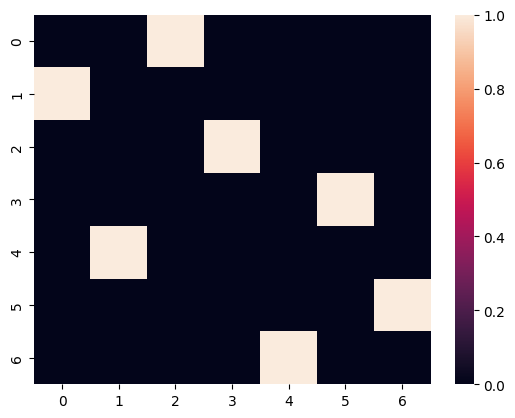

In [9]:
sns.heatmap(X_qsoln)

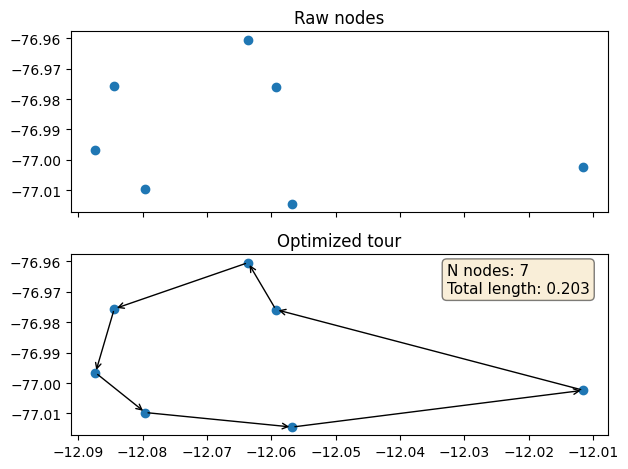

In [10]:
path = np.argwhere(X_qsoln==1)
orden = path[0].tolist()
for i in range(1, N):
    row = orden[-1]
    orden.append(path[row,1])
tsp_plotter(points, orden)

## Other Notes

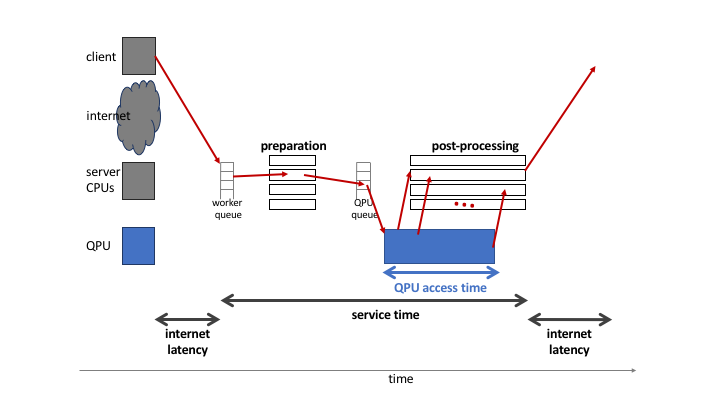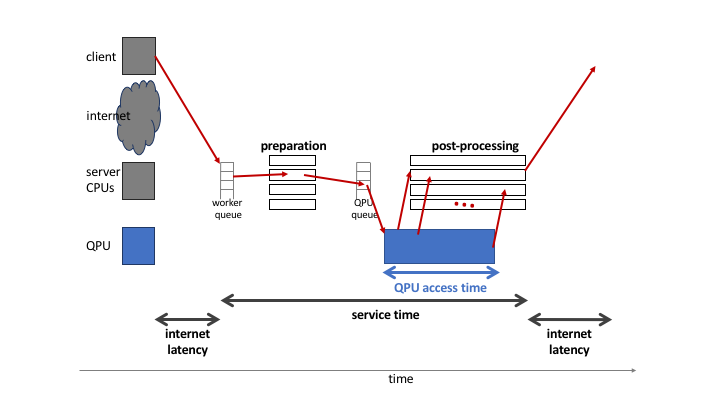